# Image Classfication

In this notebook well perform image classification using a convlutional neural network. Well be using the CIFAR-10 dataset which contains 60000 32x32 colour images of 10 classes, with 6000 images per a class. 
Download the dataset from here [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) and unzip it.

# Images Processing

First we need to get the images into a format that we can feed into our neural network. We want the images in a numpy matrix where each row represents a picture.


In [41]:
import pickle 
from  PIL import Image
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

The images have been saved in a format for python called [pickle](https://pythontips.com/2013/08/02/what-is-pickle-in-python/). This allows us to read each image easily into numpy arrays. The images have been split into 6 batches, each batch contains 10,000 images.

In [42]:
with open('data/data_batch_1', 'rb') as f:
    data= pickle.load(f, encoding='bytes')

data.keys()

dict_keys([b'labels', b'filenames', b'data', b'batch_label'])

In [43]:
data

{b'batch_label': b'training batch 1 of 5',
 b'data': array([[ 59,  43,  50, ..., 140,  84,  72],
        [154, 126, 105, ..., 139, 142, 144],
        [255, 253, 253, ...,  83,  83,  84],
        ..., 
        [ 71,  60,  74, ...,  68,  69,  68],
        [250, 254, 211, ..., 215, 255, 254],
        [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8),
 b'filenames': [b'leptodactylus_pentadactylus_s_000004.png',
  b'camion_s_000148.png',
  b'tipper_truck_s_001250.png',
  b'american_elk_s_001521.png',
  b'station_wagon_s_000293.png',
  b'coupe_s_001735.png',
  b'cassowary_s_001300.png',
  b'cow_pony_s_001168.png',
  b'sea_boat_s_001584.png',
  b'tabby_s_001355.png',
  b'muntjac_s_001000.png',
  b'arabian_s_001354.png',
  b'quarter_horse_s_000672.png',
  b'passerine_s_000343.png',
  b'camion_s_001895.png',
  b'trailer_truck_s_000335.png',
  b'dumper_s_000821.png',
  b'alley_cat_s_000200.png',
  b'accentor_s_000677.png',
  b'frog_s_001671.png',
  b'capreolus_capreolus_s_000051.png',
  b'tomca

The dataset is labeled 0-9, each number corresponds to which class the image belongs

In [44]:
labels = data[b'labels']
labels[:10]

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

Since the images have been flattend into a vector of pixels well have to reshape them before we can view them.

In [45]:
imgs = data[b'data']
imgs.shape # 10000 * (32 * 32 * 3)

(10000, 3072)

First well reshape and then transpose the dimensions, after that we can plot the image to see a rather pixalted lorry. For the purpose of pratice it's simpler to work with lower quality images, since well be able to train our models quickers, however the same code can be adapted for bigger images.

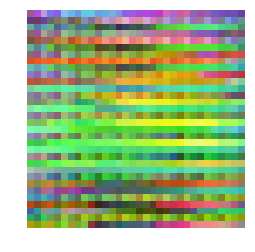

In [58]:
single_img =  np.reshape(imgs[1],(3,32,32)).transpose([1,2,0])  #transpose for plt.imshow to read in the format of (h,w,c)
plt.axis('off')
plt.imshow(single_img)

We can reshape all of the images using numpy

In [47]:
imgs = imgs.reshape(10000,3,32,32)
imgs = imgs.transpose([0,2,3,1])
imgs.shape

(10000, 32, 32, 3)

Lets plot the first occurence of each class

In [48]:
ten_imgs = imgs[[labels.index(i) for i in range(10)]]

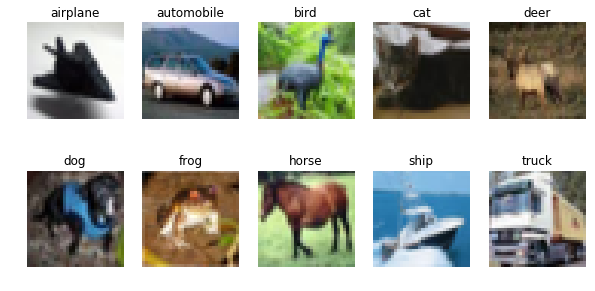

In [49]:
fig, ax_arr = plt.subplots(2,5)
img_lables = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
iterable = zip(ten_imgs,ax_arr.flatten(),img_lables)
for img, ax,label in iterable:
    ax.imshow(img)
    ax.set_axis_off()
    ax.set_title(label)

fig.set_size_inches(10,5)

## Convert to grayscale

Since we don't want to work with 3 dimensions we can convert the image to gray scale by taking the average pixel value for across all 3 colour channels.

Text(0.5,1,'Dog')

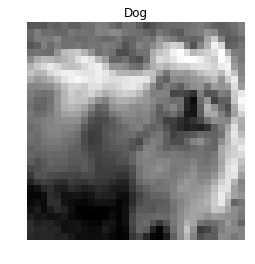

In [50]:
grey_imgs = np.mean(imgs,axis=3,keepdims=True)
plt.imshow(np.squeeze(grey_imgs[40]),cmap="gray")
plt.axis("off");
plt.title("Dog")

All together in one function

In [51]:
def read_imgs(path,to_gray = True):
    
    with open(path, 'rb') as f:
        data= pickle.load(f, encoding='bytes')
   
    labels = data[b'labels']
    labels = np.array(labels)
    imgs = data[b'data']
    imgs = imgs.astype("float32")
    
    imgs = imgs.reshape(imgs.shape[0],3,32,32)
    imgs = imgs.transpose([0,2,3,1])
    if to_gray:
        imgs = np.mean(imgs,axis=3,keepdims=True)
        
    return imgs,labels


In [52]:
grey_imgs,labels = read_imgs("data/data_batch_1")

## Image normalization

Normalization will help our neural network perform better and train faster. From each image we need to subtract the mean and divide by the standard deviation

$$ x_{norm} = \frac{x - \mu}{\sigma} $$

In [53]:
mean_img = np.mean(grey_imgs,axis=0)
std_img = np.std(grey_imgs,axis=0)
grey_imgs = (grey_imgs - mean_img) / std_img
grey_imgs = grey_imgs.astype("float32")

# The Network

The rough overiew of our  network structure is shown bellow.

![](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-07-at-7.26.20-AM.png)


Essentialy we apply convolution then pooling and repeat. At the end we have a fully connected layers which we can apply softmax to , allowing us to output a vector of probabilities. We will also add some dropout layers which helps the model generalise better and reduces overfitting.


# Keras 

Since the tensorflow API can get quite verbose, we can use keras. Keras is a high level library that simplifys the constructions of model. It's likely that keras will be included by default  with tensorflow in the future [(1)](https://www.youtube.com/watch?v=UeheTiBJ0Io)  [(2)](https://github.com/keras-team/keras/issues/5299#issuecomment-278166426). 

In [54]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 1280
num_classes = 10
epochs = 50

# input image dimensions
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 1)

Using TensorFlow backend.


In [1]:
#read in data
data = [ read_imgs(f"data/data_batch_{i}") for i in range(1,6) ]
imgs = np.vstack([ data[i][0] for i in range(5)])
labels = np.hstack([ data[i][1] for i in range(5)])
#create train and test sets
x_train,y_train = imgs,labels
x_test, y_test = read_imgs("./cifar-10-batches-py/test_batch")
#Onehot encode
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

SyntaxError: invalid syntax (<ipython-input-1-e35032cf9f12>, line 2)

In [108]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [110]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.9222 - acc: 0.3723 - val_loss: 1.7089 - val_acc: 0.4195
Epoch 2/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.5542 - acc: 0.4648 - val_loss: 1.4364 - val_acc: 0.4988
Epoch 3/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.4800 - acc: 0.4916 - val_loss: 1.4813 - val_acc: 0.4847
Epoch 4/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.3698 - acc: 0.5256 - val_loss: 1.3790 - val_acc: 0.5313
Epoch 5/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.3120 - acc: 0.5493 - val_loss: 1.3016 - val_acc: 0.5532
Epoch 6/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2210 - acc: 0.5793 - val_loss: 1.2705 - val_acc: 0.5717
Epoch 7/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.1621 - acc: 0.5988 - val_loss: 1.4094 - val_acc

# Saving and Loading models

After training we'll want to save the model

In [96]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model


We can load it back into memory and use it to make predictions.

In [ ]:

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

preds  = model.predict(x_test[:10])
np.argmax(preds,axis=0)

# Tensorflow

Bellow is the same model but implemented using tensorflow.

In [15]:
import tensorflow as tf

We a using a  variable_scope with `tf.AUTO_REUSE` this allows us to
create variables if they do not exist, and reuse them otherwise, this makes working inside a jupyter notebook easier, since we can run the cell multiple times without it causing an error.

In [21]:
with tf.variable_scope('convnet', reuse=tf.AUTO_REUSE):    
    
    learning_rate = 0.001
    dropout_rate = tf.placeholder("float32",name="dropout_rate")
    X = tf.placeholder("float32",shape=(None,32,32,1) )
    Y = tf.placeholder("int64",shape=(None))
    
    # Convolution Layer with 32 filters and a kernel size of 5
    conv1 = tf.layers.conv2d(X, 32, 5, activation=tf.nn.relu)
    # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
    conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

    # Convolution Layer with 64 filters and a kernel size of 3
    conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
    # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
    conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
    
    # Flatten the data to a 1-D vector for the fully connected layer
    fc1 = tf.contrib.layers.flatten(conv2)
    fc1 = tf.contrib.layers.fully_connected(fc1, 1024)
     # Apply Dropout=
    fc1 = tf.layers.dropout(fc1, rate=dropout_rate, training=True)

    # Logits Layer with 10 classes
    logits = tf.contrib.layers.fully_connected(fc1,10)
    
    #Predictions
    pred_classes = tf.argmax(logits,axis=1)
    pred_probs = tf.nn.softmax(logits)

    correct_pred = tf.equal(pred_classes, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=tf.cast(Y, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    


The batch [generator](https://stackoverflow.com/questions/1756096/understanding-generators-in-python) bellow will allow us to easily feed data into our model. 

In [22]:
def batch_generator(x,y,batch_size):
    
    n = x.shape[0]
    i1,i2 = 0,batch_size
    
    while True:
        if i2 > n:
            i1,i2 = 0,batch_size
        output = x[i1:i2],y[i1:i2]
        i1,i2 = i1+batch_size, i2+batch_size
        yield output


In [23]:
nepochs = 10000
display_step = 1000
batch = batch_generator(grey_imgs,labels,128)
error_rate = []

Now that we've create our graph and a function to feed in the data we can train the model

In [ ]:
sess = tf.Session()   
sess.run(tf.global_variables_initializer())
    
for step in range(nepochs):
    #Get next batch of data for model
    batch_x, batch_y = next(batch)
    #Train model
    feed_dict = {X:batch_x,Y:batch_y,dropout_rate:0.2}
    sess.run(train_op,feed_dict)
    if step % display_step == 0:            
        
        #Check model accuracy
        feed_dict={X: batch_x,Y: batch_y,dropout_rate: 0.0}
        loss, acc = sess.run([loss_op, accuracy], feed_dict)
        error_rate.append(acc)
                
        print("Step " + str(step) + ",  Loss = " + \
              "{:.4f}".format(loss) + ", Accuracy = " + \
                "{:.3f}".format(acc))